In [ ]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pylab
import statsmodels.api as sm
import statsmodels.stats as smt

In [ ]:
url_lol = 'https://raw.githubusercontent.com/michellyrds/mqaa/master/datasets/high_diamond_ranked_10min.csv'

url = url_lol
raw_data = pd.read_csv(url)

raw_data.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,0,0,15899,7.0,18161,225,42,698,101,22.5,1589.9,36,5,1,3,5,2,0,0,0,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,0,0,16874,6.8,16967,225,53,2411,1563,22.5,1687.4,57,1,0,6,7,9,0,0,0,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,0,0,15305,6.4,16138,209,48,-2615,-800,20.9,1530.5,15,0,1,13,5,11,1,1,0,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,0,0,16401,7.2,18527,189,61,-1979,-771,18.9,1640.1,15,2,1,7,7,5,2,1,1,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,0,0,15057,6.8,16805,220,39,-1548,-1574,22.0,1505.7,16,2,0,5,4,4,0,0,0,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


# Análise fatorial

## Objetivo
**Agrupar variáveis por meio de suas correlações para reduzi-lás em fatores.** Para tal, utilizaremos a análise fatorial R para analisar o conjunto de variáveis e identificar as dimensões (fatores) latentas.



## Planejamento da análise fatorial

- Correlações entre variáveis;
- Seleção de variáveis e medidas: nesse primeiro momento, selecionaremos **todas as 20** variáveis referentes à composição e desempenho do time azul nos primeiros 10 minutos de partida;
<!--- , com exceção das variáveis dicotômicas: _blueWins_ e _blueFirstBlood_: --->
- Tamanho da amostra: inicialmente, 9876 linhas.

In [ ]:
df = raw_data.filter(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'])
df.info

<bound method DataFrame.info of       blueWins  blueWardsPlaced  ...  blueCSPerMin  blueGoldPerMin
0            0               28  ...          19.5          1721.0
1            0               12  ...          17.4          1471.2
2            0               15  ...          18.6          1611.3
3            0               43  ...          20.1          1515.7
4            0               75  ...          21.0          1640.0
...        ...              ...  ...           ...             ...
9874         1               17  ...          21.1          1776.5
9875         1               54  ...          23.3          1623.8
9876         0               23  ...          21.0          1590.3
9877         0               14  ...          22.4          1445.9
9878         1               18  ...          20.7          1626.6

[9879 rows x 20 columns]>

Gerando a matriz de correlação das variáveis selecionadas:

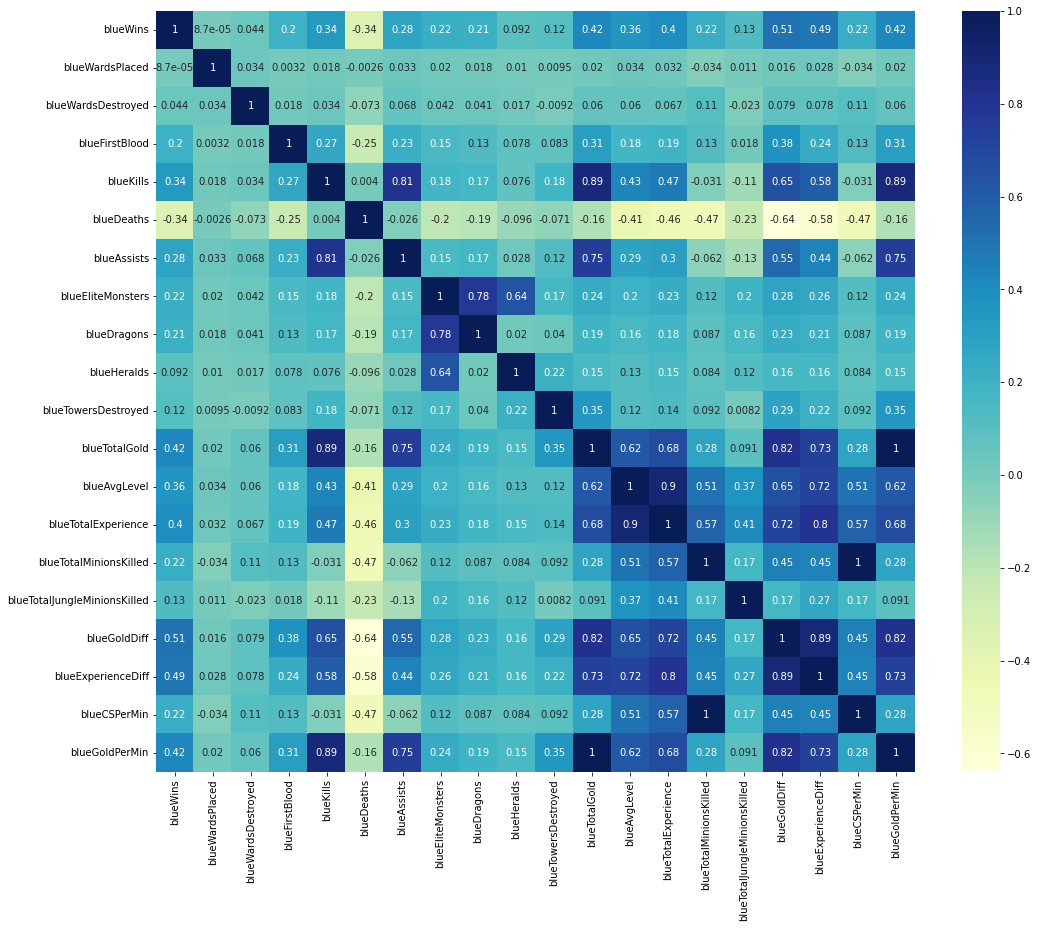

In [ ]:
fig = plt.figure(figsize=(17,14))
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
plt.show()

Inspecionando visualmente, nota-se um número substancial de correlações maiores que 0.30, um indicio que podemos prosseguir com a análise fatorial.

## Suposições
- Fundamentação conceitual
    - Suposição: existe alguma estrutura subjacente no conjunto de variá-
veis escolhidas;
    - A amostra é homogênea;
- Medidas gerais de intercorrelação
- Fatores que afetam a correlação (caso seja usada):
  - Desvio de normalidade;
  - Homoscedasticidade;
  - Linearidade.


Utilizaremos o teste de esfericidade de Bartlett estatisticamente
significante para verificar se existe correlações suficientes para continuar com a análise.

In [ ]:
# matriz de correlação, fazer teste de esfericidade de Bartlett e Medidas de valores de adequação da amostra > 0.5(MSA)
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value,p_value=calculate_bartlett_sphericity(df)
print("chi_square_value: {}\np-value: {}".format(chi_square_value, p_value))

chi_square_value: 1159641.6767525927
p-value: 0.0


Como p-value é 0, o teste possui significância estatística, indicando que a matriz é de fato uma matriz de correlação e não uma matriz identidade.

Outra medida que podemos usar comparar as relações entre as variáveis é pelo teste de KMO

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(df)

print("coeficiente de KMO: {}\n".format(kmo_model))

print("coeficiente de KMO de cada variável:\n{}".format(kmo_all))

coeficiente de KMO: 0.6915617111980871

coeficiente de KMO de cada variável:
[0.98352681 0.3564556  0.78273317 0.9043531  0.65236411 0.58231074
 0.84387069 0.8433294  0.58566635 0.42214518 0.39332533 0.62730248
 0.89189156 0.80748735 0.5465951  0.42267518 0.75179332 0.87509634
 0.5465951  0.62730248]


/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


Dado que o coeficiente de KMO é 0.69, podemos interpretar que os dados são razoáveis para aplicação da análise fatorial.

Eliminando variáveis com MSA < 0.5 até obtermos coefientes adequados:

In [ ]:
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'],
      dtype='object')

In [ ]:
df = raw_data.filter(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'])

#df = df.drop(labels=['blueWins', 'blueWardsPlaced', 'blueTowersDestroyed', 'blueHeralds', 'blueTotalJungleMinionsKilled'], axis=1)
df = df.drop(labels=['blueWins', 'blueWardsPlaced', 'blueTowersDestroyed', 'blueHeralds', 'blueTotalJungleMinionsKilled', 'blueWardsDestroyed', 'blueDeaths'], axis=1)


In [ ]:
df = df.drop(labels=['blueWins', 'blueWardsPlaced', 'blueTowersDestroyed',
                     'blueHeralds', 'blueTotalJungleMinionsKilled', 
                     'blueWardsDestroyed', 'blueDeaths'], axis=1)

kmo_all,kmo_model=calculate_kmo(df)

print("coeficiente de KMO: {}\n".format(kmo_model))

print("coeficiente de KMO de cada variável:\n{}".format(kmo_all))

print(df.columns)

coeficiente de KMO: 0.7332898175794236

coeficiente de KMO de cada variável:
[0.81821749 0.67734535 0.91141563 0.61410024 0.57741939 0.69685161
 0.86302794 0.81004401 0.58313975 0.81298534 0.8293541  0.58313975
 0.6968516 ]
Index(['blueFirstBlood', 'blueKills', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience',
       'blueTotalMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


Após remover iterativamente os coeficientes de KMO das variáveis < 0.5, obtemos um coeficiente geral de 0.733, que é considerado médio para análise fatorial.

Gerando a matriz de correlação com as devidas variáveis omitidas:

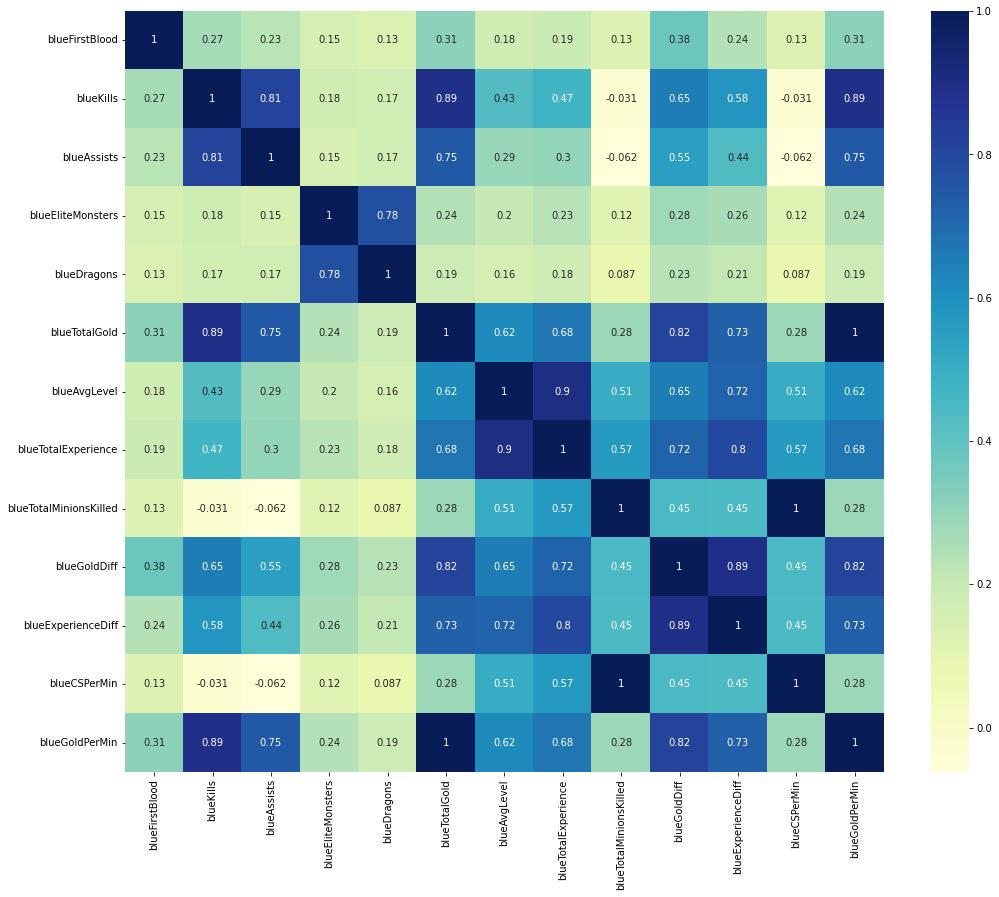

In [ ]:
fig = plt.figure(figsize=(17,14))
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
plt.show()

## Criando a estrutura fatorial
- Modelo fatorial: análise de componentes principais 
- Número de fatores: 3 (vide cálculo abaixo)

Extraindo o número de fatores pelo critério de Kaiser e pelo gráfico de Scree:

In [ ]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation=None)
fa.fit(df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
for number in ev:
  print('%.3f'%(number))


6.496
2.305
1.632
0.910
0.619
0.368
0.244
0.196
0.099
0.079
0.053
0.000
-0.000


3 fatores eigenvalues > 1, então selecionaremos 3 fatores.

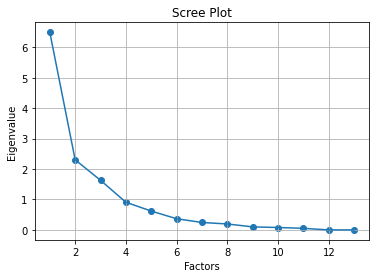

In [ ]:
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Executando a análise fatorial e printando sua estrutura:

In [ ]:
"""
 rotation (str, optional) 
# The type of rotation to perform after fitting the factor analysis model.
# If set to None, no rotation will be performed, nor will any associated 
Kaiser normalization.
"""
fa = FactorAnalyzer(method="principal", rotation=None)

# fa.fit(dataset, n_factors)
fa.fit(df, 3)

fa.loadings_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


array([[ 0.36522103, -0.10440887,  0.09485107],
       [ 0.76307537, -0.56436342, -0.12160036],
       [ 0.63705799, -0.59997042, -0.09268341],
       [ 0.35164886, -0.02612983,  0.87215407],
       [ 0.30423861, -0.05638686,  0.88919323],
       [ 0.92195277, -0.27432499, -0.12237343],
       [ 0.79038474,  0.28323405, -0.08178212],
       [ 0.84678935,  0.30548492, -0.07363466],
       [ 0.50376051,  0.79907714, -0.03628786],
       [ 0.91490477,  0.00646888, -0.03339153],
       [ 0.8786601 ,  0.10199893, -0.04583943],
       [ 0.50376051,  0.79907714, -0.03628786],
       [ 0.92195277, -0.27432499, -0.12237343]])

Variância de cada fator:

In [ ]:
fa.get_factor_variance()

(array([6.49612903, 2.30477919, 1.63160165]),
 array([0.49970223, 0.17729071, 0.12550782]),
 array([0.49970223, 0.67699294, 0.80250076]))

## Determinação de fatores e avaliação do ajuste geral
- Método de rotação fatorial: Varimax

In [ ]:
# exemplo: rotação pelo critério varimax, consultar documentação para + detalhes: https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html
import pandas as pd
from factor_analyzer import FactorAnalyzer, Rotator

fa = FactorAnalyzer(method="principal",rotation="varimax")

fa.fit(df, 3)

rotator = Rotator()

fa_rot = rotator.fit_transform(fa.loadings_)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


In [ ]:
print(df.columns)

df_fa = pd.DataFrame(fa_rot,index=['blueFirstBlood', 'blueKills', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience',
       'blueTotalMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'],columns=['F1','F2', 'F3'])

print(df_fa)

Index(['blueFirstBlood', 'blueKills', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience',
       'blueTotalMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'],
      dtype='object')
                              F1        F2        F3
blueFirstBlood          0.336674  0.101744  0.171997
blueKills               0.953887 -0.048702  0.057489
blueAssists             0.865138 -0.149192  0.060629
blueEliteMonsters       0.134385  0.091018  0.926633
blueDragons             0.109044  0.038561  0.934359
blueTotalGold           0.924853  0.279898  0.080810
blueAvgLevel            0.504850  0.671564  0.075803
blueTotalExperience     0.537093  0.719955  0.094820
blueTotalMinionsKilled -0.019642  0.944055  0.044605
blueGoldDiff            0.748507  0.503091  0.157619
blueExperienceDiff      0.669082  0.564507  0.134941
blueCSPerMin           -0.019642  0.944055  0.044605
blueGoldPerMin          

## Validação da análise fatorial

### Matriz simplificada de cargas fatoriais não-rotacionada

|   |f1 |f2 |f3 |
|---|---|---|---|
|blueFirstBlood|0.36522103|-0.10440887| 0.09485107|
|blueKills|0.76307537|-0.56436342|-0.12160036|
|blueAssists|0.63705799|-0.59997042|-0.09268341|
|blueEliteMonsters|0.35164886|-0.02612983| 0.87215407|
|BlueDragons|0.30423861|-0.05638686| 0.88919323|
|blueTotalGold|0.92195277|-0.27432499|-0.12237343|
|blueAvgLevel|0.79038474| 0.28323405|-0.08178212|
|blueTotalExperience|0.84678935| 0.30548492|-0.07363466|
|blueTotalMinionsKilled|0.50376051| 0.79907714|-0.03628786|
|blueGoldDiff|0.91490477| 0.00646888|-0.03339153|
|blueExperienceDiff|0.8786601 | 0.10199893|-0.04583943|
|blueCSPerMin|0.50376051| 0.79907714|-0.03628786|
|blueGoldPerMIn|0.92195277|-0.27432499|-0.12237343|

### Matriz VARIMAX de cargas fatoriais rotacionada
|   |f1 |f2 |f3 |
|---|---|---|---|
blueFirstBlood|**0.336674**|0.101744|0.171997|
blueKills|**0.953887**|-0.048702|0.057489|
blueAssists|**0.865138**|-0.149192|0.060629|
blueEliteMonsters|0.134385|0.091018|**0.926633**|
blueDragons|0.109044|0.038561|**0.934359**|
blueTotalGold|**0.924853**|0.279898|0.080810|
blueAvgLevel|0.504850|**0.671564**|0.075803|
blueTotalExperience|0.537093|**0.719955**|0.094820|
blueTotalMinionsKilled|-0.019642|**0.944055**|0.044605|
blueGoldDiff|**0.748507**|0.503091|0.157619|
blueExperienceDiff|**0.669082**|0.564507|0.134941|
blueCSPerMin|-0.019642|**0.944055**|0.044605|
blueGoldPerMin|**0.924853**|0.279898|0.080810|


### Matriz simplificada de cargas fatoriais rotacionada
|   |f1 |f2 |f3 |
|---|---|---|---|
|blueFirstBlood|**0.336674**|||
|blueKills|**0.953887**|||
|blueAssists|**0.865138**|||
|blueTotalGold|**0.924853**|||
|blueGoldPerMin|**0.924853**|||
|blueTotalMinionsKilled||**0.944055**||
|blueCSPerMin||**0.944055**||
|blueAvgLevel|0.504850|**0.671564**||
|blueTotalExperience|0.537093|**0.719955**||
|blueGoldDiff|**0.748507**|0.503091||
|blueExperienceDiff|**0.669082**|0.564507||
|blueEliteMonsters|||**0.926633**|
|blueDragons|||**0.934359**|



### Matriz de cargas fatoriais rotacionada com blueAvgLevel, blueTotalExperience, blueGoldDiff	e blueExperienceDiff excluídas

|   |f1 |f2 |f3 |
|---|---|---|---|
|blueFirstBlood|**0.336674**|||
|blueKills|**0.953887**|||
|blueAssists|**0.865138**|||
|blueTotalGold|**0.924853**|||
|blueGoldPerMin|**0.924853**|||
|blueTotalMinionsKilled||**0.944055**||
|blueCSPerMin||**0.944055**||
|blueEliteMonsters|||**0.926633**|
|blueDragons|||**0.934359**|



### Rotulando os fatores

|Variáveis|Abates de jogadores|Abates de tropas|Objetivos neutros|
|---|---|---|---|
|blueFirstBlood|**0.336674**|||
|blueKills|**0.953887**|||
|blueAssists|**0.865138**|||
|blueTotalGold|**0.924853**|||
|blueGoldPerMin|**0.924853**|||
|blueTotalMinionsKilled||**0.944055**||
|blueCSPerMin||**0.944055**||
|blueEliteMonsters|||**0.926633**|
|blueDragons|||**0.934359**|



## Referências

**Análise multivariada de dados**. Por Joseph F. Hair, William C. Black, Barry J. Babin, Rolph E. Anderson, Ronald L. Tatham

---
https://www.datacamp.com/community/tutorials/introduction-factor-analysis

----

https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html